## Исследование данных о российском кинопрокате



### Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Отключаем "научную запись" вещественных чисел
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Открытие mkrf_movies.csv

In [2]:
mkrf_movies = pd.read_csv('...')
display(mkrf_movies.head(1))

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"


Переименуем колонку `puNumber` в `pu_number`:

In [3]:
mkrf_movies = mkrf_movies.rename(columns={'puNumber': 'pu_number'})
display(mkrf_movies.head(1))

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"


Проверяем, нет ли аномалий среди значений прокатного удостоверения (посколько по нему будем делать слияние `mkrf_movies` и `mkrf_shows`):

In [4]:
display(mkrf_movies['pu_number'].sort_values().unique())

array([' 111004112', '111000110', '111000111', ..., '231001012',
       '231001111', 'нет'], dtype=object)

Аномалии есть, а именно:

- начинающийся в пробела (`' 111004112'`), возможно есть и заканчивающиеся лишним пробелом, попробуем это выяснить далее;

- со значением `нет`, также далее оценим их количество

Сначала оценим количество фильмов, имеющих пробел в начале или в конце значения в `pu_number`:

In [5]:
startswith_space = mkrf_movies['pu_number'].str.startswith(' ')
endswith_space = mkrf_movies['pu_number'].str.endswith(' ')

print(f'''Количество прокатных удостоверений, начинающихся или заканчивающихся пробелом:\
      {mkrf_movies[(startswith_space) | (endswith_space)]['pu_number'].count()}''')

Количество прокатных удостоверений, начинающихся или заканчивающихся пробелом:      1


В принципе, ничего страшного в таких значениях нет, поскольку при приведении поля к целому типу через `astype(int)` такой вид аномалий будет успешно обработан.

Что касается фильмов со значением `нет` для столбца `pu_number`, то здесь проблема критичная в том смысле, что вызов `astype(int)` завершится аварийно при попытке выполнить приведение `нет` в целому типу. Оцениваем количество фильмов с такой аномалией:

In [6]:
print(f'''Количество прокатных удостоверений со значением "нет":\
      {mkrf_movies[mkrf_movies['pu_number'] == 'нет']['pu_number'].count()}''')

Количество прокатных удостоверений со значением "нет":      1


Такой фильм только один - присваиваем ему значением `-1` и приводим столбец к целому типу:

In [7]:
mkrf_movies.loc[mkrf_movies['pu_number'] == 'нет', 'pu_number'] = -1
mkrf_movies['pu_number'] = mkrf_movies['pu_number'].astype(int)

display(mkrf_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int32  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

None

#### Открытие mkrf_shows.csv

In [8]:
mkrf_shows = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_shows.csv')

Опять же, переименуем колонку `puNumber` в `pu_number`:

In [9]:
mkrf_shows = mkrf_shows.rename(columns={'puNumber': 'pu_number'})
display(mkrf_shows.head(3))
display(mkrf_shows.info())

,pu_number,box_office
0,111000113,2450.000
1,111000115,61040.000
2,111000116,153030013.400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pu_number   3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


None

Соединим вместе `mkrf_movies` и `mkrf_shows` так, чтобы все значения из `mkrf_movies` обязательно вошли в результирующий датафрейм:

In [10]:
mkrf = mkrf_movies.merge(mkrf_shows, how='left')

display(mkrf.head(3))
display(mkrf.info())

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int32  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

None

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

Глядя на выдачу `mkrf.info()` выше, можно увидеть, что столбец `show_start_date` нуждается в приведении к типу `datetime`.

Также посмотрим на столбцы `financing_source` и `ratings`, которые, судя по указанному для них типу `object`, в настоящее время являются строками:

In [11]:
display(mkrf['financing_source'].unique())
display(mkrf['ratings'].unique())

array([nan, 'Министерство культуры', 'Фонд кино',
       'Министерство культуры, Фонд кино'], dtype=object)

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

Оба столбца содержат пропуски. В остальном по своим значениям столбец `financing_source` не вызывает вопросов, а вот в столбце `ratings` наблюдаются странные значения, где в качестве рейтинга указано какое-то значение в процентах, причём появление символа `%`, судя по всему, привело к тому, что и сам столбец приобрёл строковый тип.
Попробуем понять, сколько фильмов с рейтингом, содержащим `%`, и что можно с этим сделать.

In [12]:
ratings_with_percent_condition = (mkrf['ratings'].notna()) & (mkrf['ratings'].str.contains('%'))

print(f"Фильмов с рейтингом в '%': {mkrf[ratings_with_percent_condition]['ratings'].count()} штук(и)")
display(mkrf[ratings_with_percent_condition][['title', 'pu_number', 'show_start_date', 'director', 'ratings']])

Фильмов с рейтингом в '%': 29 штук(и)


,title,pu_number,show_start_date,director,ratings
259,Прошлое,221030715,2015-07-29T12:00:00.000Z,Эктор Бабенко,99%
811,От винта!,114000212,2012-08-06T12:00:00.000Z,О.Лопато,28%
1053,Песочный человек,121029212,2012-11-29T12:00:00.000Z,Питер Луизи,97%
1341,Сказка о добре и Вре,111008913,2013-11-15T12:00:00.000Z,Е.Шиляева,99%
1805,Спираль.,111001014,2014-01-30T12:00:00.000Z,А.Волгин,99%
1874,Короткие истории о любви 2,121002615,2015-02-13T12:00:00.000Z,"Мэтью Аувро, Лео Брайдл, Бен Бренд, Ден Кларк,...",83%
1899,Золушка /По сказке Шарля Перро/. Холодное торж...,121003615,2015-02-27T12:00:00.000Z,Кеннет Брана,64%
2126,Поездка к матери,111002015,2015-03-02T12:00:00.000Z,М.Косырев-Нестеров,91%
2146,Главный,111003415,2015-03-27T12:00:00.000Z,Ю.Кара,94%
2438,Самый рыжий Лис,111012715,2015-07-30T12:00:00.000Z,А.Стреляная,62%


Таких фильмов мало, только `29`.

В то же время не очень понятно, как можно привести процентное значение в рейтинг от `0` до `10` - к примеру, фильм "_Спираль_" в таблице выше имеет рейтинг `99%`, при этом его рейтинг на сайте "Кинопоиска" составляет лишь только `5.046` (https://www.kinopoisk.ru/film/809156/).

После поиска ещё части фильмов из таблицы выше на сайте "Кинопоиска" было обнаружено, что значительная часть фильмов из этих `29` вообще не имеет рейтинга на данном ресурсе. Поэтому выставим всем таким фильмам значение рейтинга равное `0` (строковое, затем оно будет приведено к типу `float`) как признак того, что у данного фильма нет рейтинга:

In [13]:
mkrf.loc[ratings_with_percent_condition, 'ratings'] = '0'

# Делаем приведение типов
mkrf = mkrf.assign(
    # Столбец "show_start_date" приводим к "datetime"
    show_start_date = lambda x: pd.to_datetime(mkrf['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%f'),
    
    # Столбец "ratings" переводим в вещественный тип
    ratings = lambda x: pd.to_numeric(x['ratings'])
)

mkrf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   pu_number              7486 non-null   int32              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

#### Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

In [14]:
mkrf.isna().sum()

title                       0
pu_number                   0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   967
genres                    976
box_office               4328
dtype: int64

Заполним пропуски в следующих строковых столбцах:

- `director`
- `genres`
- `producer`
- `film_studio`
-`production_country`

Подставим в качестве замены пустую строку. Пустая строка выглядит предпочтительнее пропуска в том аспекте, что ячейка таблицы со значением `NaN` имеет тип `float`, и попытка работы с такой ячейкой как со строкой приведёт к проблеме - возникнет исключение. Но необходимость работы с этими столбцами как со строками вполне может возникнуть далее в ходе исследования, ведь все непустые значения в этих столбцах именно строки.

In [15]:
mkrf[['director', 'genres', 'producer', 'film_studio', 'production_country']] =\
    mkrf[['director', 'genres', 'producer', 'film_studio', 'production_country']].fillna(value='')

mkrf.isna().sum()

title                       0
pu_number                   0
show_start_date             0
type                        0
film_studio                 0
production_country          0
director                    0
producer                    0
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   967
genres                      0
box_office               4328
dtype: int64

#### Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

In [16]:
mkrf.duplicated().sum()

0

Дубликаты в нашем наборе данных отсутсвуют.

#### Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

Посмотрим на значения в поле `type`:

In [17]:
mkrf['type'].value_counts()

Художественный                4520
 Художественный               1389
Анимационный                   828
Прочие                         406
Документальный                 288
Научно-популярный               53
Музыкально-развлекательный       1
 Анимационный                    1
Name: type, dtype: int64

В выдаче выше можно видеть лишние пробельные символы в начале строк " Художественный" и " Анимационный", избавимся от них и убедимся в том, что это удалось сделать:

In [18]:
mkrf['type'] = mkrf['type'].str.strip()
mkrf['type'].value_counts()

Художественный                5909
Анимационный                   829
Прочие                         406
Документальный                 288
Научно-популярный               53
Музыкально-развлекательный       1
Name: type, dtype: int64

#### Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

Попробуем исследовать столбцы с количественными значениями по гистограммам, а также воспользуемся методом `DataFrame.describe()` для вывода характеристик распределений:

In [19]:
def plot_numeric_category_histogram(df, category, bins, ax, range_tuple, xticks):
    """ Строит гистограмму для признака датафрейма "df", переданного параметром "category" на оси,
    переданной параметром "ax"
    """
    if range_tuple and xticks:
        df[category].plot(kind='hist', bins=bins, range=range_tuple, xticks=xticks, grid=True, ax=ax)
        ax.set_title(f'Усечённая гистограмма для категории "{category}"', {'fontsize': 13})
    else:
        df[category].plot(kind='hist', bins=bins, grid=True, ax=ax)
        ax.set_title(f'Полная гистограмма для категории "{category}"', {'fontsize': 13})
        
    ax.set_xlabel(category)
    ax.set_ylabel('Частота')
    ax.ticklabel_format(axis='x', style='plain')
    ax.tick_params(axis='x', rotation=90)  

# Выводим информацию о распределениях количественных признаков
mkrf[['refundable_support', 'nonrefundable_support', 'budget', 'box_office']].describe()

,refundable_support,nonrefundable_support,budget,box_office
count,332.000,332.000,332.000,3158.000
mean,11864457.831,48980988.892,127229716.684,76478696.161
std,24916555.264,59980117.923,188588333.115,240353122.823
min,0.000,0.000,0.000,0.000
25%,0.000,25000000.000,42000000.000,86239.000
50%,0.000,30000000.000,68649916.000,2327987.550
75%,15000000.000,40375000.000,141985319.500,23979671.025
max,180000000.000,400000000.000,2305074303.000,3073568690.790


Из результатов выше видно, что количество фильмов, для которых известна информация о бюджете и поддержке, крайне невелика - `332` фильма, информация о сборах доступна для б_о_льшего количества фильмов - `3158`.

Строим гистограммы - по паре на каждую категорию - в усечённом (для более наглядного представления распределения в районе мод(ы)) и полном вариантах.

Начнём с гистограмм для категории возвратных средств поддержки (`refundable_support`):

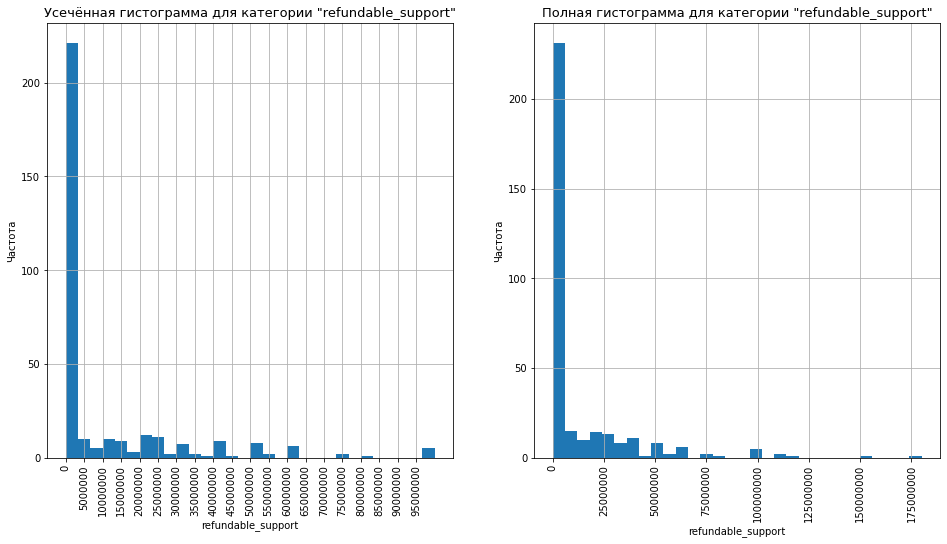

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

range_tuple = (0, 100_000_000)
xticks = range(0, 100_000_000, 5_000_000)
plot_numeric_category_histogram(mkrf, 'refundable_support', 30, axs[0], range_tuple, xticks)
plot_numeric_category_histogram(mkrf, 'refundable_support', 30, axs[1], None, None)

Объём возвратных средств господдержки (`refundable_support`) - для данной категории нулём является не только минимальное значение, но также и мода и медиана. Можно сделать осторожный вывод о наличии тенденции очень ограниченного использования возвратных средств, возможно по причинам дополнительных ограничений на компании, которые желают воспользоваться таким способом поддержки, а также в силу того, что получение возвратных средств подразумевает поручительство (https://www.kinometro.ru/news/show/name/fond_kino_gospodderzhka_proizvodstva_5739).

В то же время заметим, что максимальным значением в данном поле является `180 млн. ₽`, и на полной гистограмме справа видны всплески частоты после `100 млн. ₽`. Нужно ли что-то делать с такими данными попробуем понять далее, выведя информацию о фильмах с необычно высокими значениями по данной категории.

Далее строим гистограммы для категории невозвратных средств поддержки (`nonrefundable_support`):

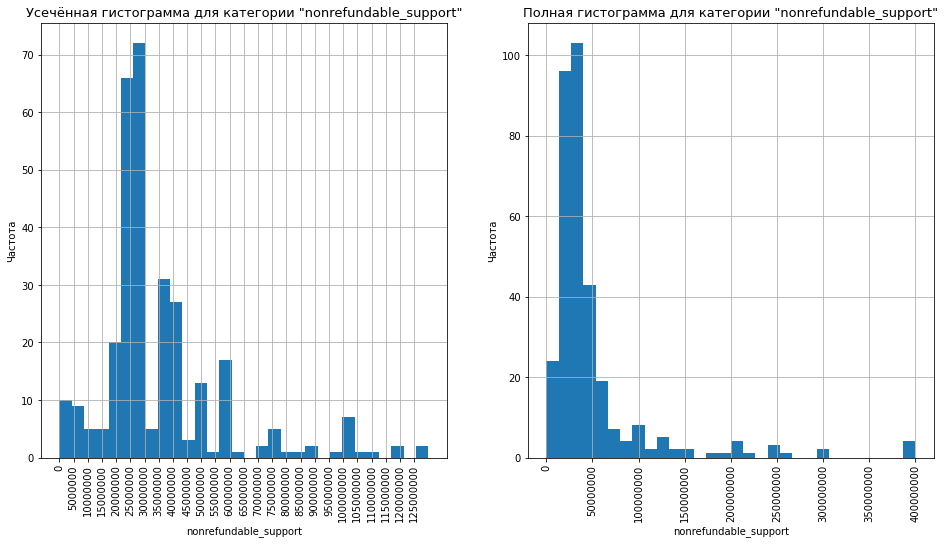

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

range_tuple = (0, 130_000_000)
xticks = range(0, 130_000_000, 5_000_000)
plot_numeric_category_histogram(mkrf, 'nonrefundable_support', 30, axs[0], range_tuple, xticks)
plot_numeric_category_histogram(mkrf, 'nonrefundable_support', 30, axs[1], None, None)

Объём невозвратных средств господдержки (`nonrefundable_support`) - здесь нулём является только минимальное значение, медиана - `30 000 000 ₽`, мода тоже около `30 000 000 ₽` (такое значение более чем у `70` фильмов). Среднее значение равно `48 980 988 ₽`, что превосходит медиану и может говорить о том, что в распределении категории присутствуют фильмы с очень высоким значением невозвратных средств. Максимальным значением вновь является крайне высокое значение - `400 млн. ₽`. Здесь на полной гистограмме справа мы снова видим всплески частоты для значений свыше `250 млн. ₽`, попробуем оценить их адекватность далее.

Теперь строим гистограммы для категории бюджета (`budget`):

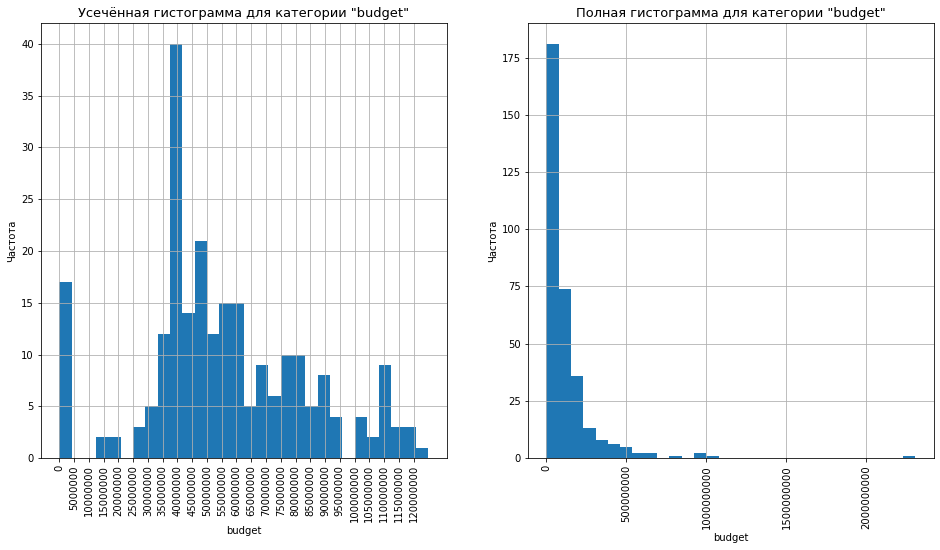

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

range_tuple = (0, 125_000_000)
xticks = range(0, 125_000_000, 5_000_000)
plot_numeric_category_histogram(mkrf, 'budget', 30, axs[0], range_tuple, xticks)
plot_numeric_category_histogram(mkrf, 'budget', 30, axs[1], None, None)

Бюджет (`budget`) - здесь сразу же бросаются в глаза около 16-17 фильмов, имеющих по какой-то причине нулевой бюджет (это можно видеть на усечённой гистограмме слева). Медиана равна `68 649 916 ₽`, модой является примерно `40 000 000 ₽` (примерно `40` фильмов). Среднее же значение равно `127 229 716 ₽`, что тоже вновь заметно больше медианы, что опять же, судя по всему, говорит о том, что в наборе данных присутствуют фильмы с весьма высоким значением бюджета. Отношение медианы к среднему - `0,53`. Максимальным значением является просто невероятное значение - `2,305 млрд. ₽`, на полной гистограмме справа виден соответствующий всплеск. Крайне интересно будет узнать, что же это был за фильм.

Переходим к гистограммам по категории сборов (`box_office`):

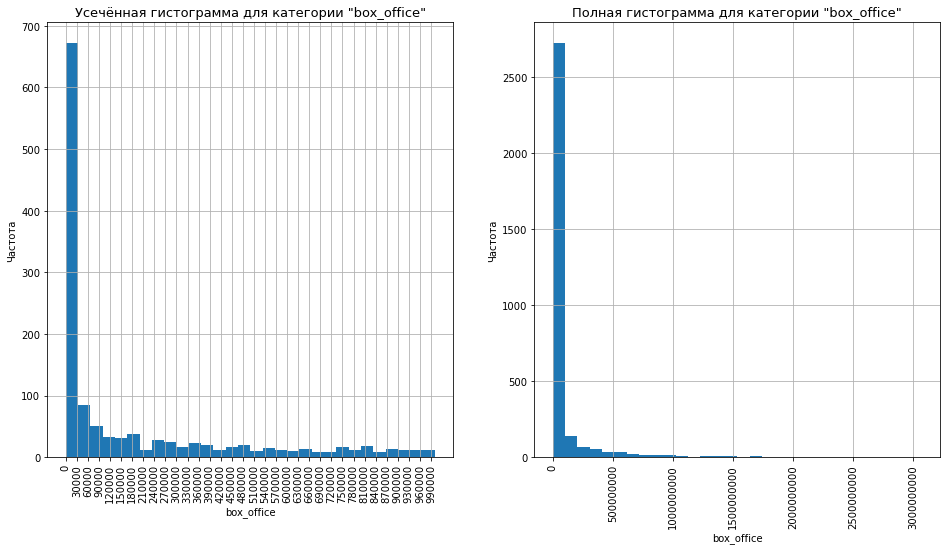

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

range_tuple = (0, 1_000_000)
xticks = range(0, 1_000_000, 30_000)
plot_numeric_category_histogram(mkrf, 'box_office', 30, axs[0], range_tuple, xticks)
plot_numeric_category_histogram(mkrf, 'box_office', 30, axs[1], None, None)

Сборы (`box_office`) - тут на усечённой гистограмме слева виден явный пик для фильмов со сборами менее `30 000 ₽` - почти `700` фильмов, мода данного распределения находится где-то в этом промежутке. Особенно интересны здесь значения среднего и медианы - `76 478 696 ₽` и `2 327 987 ₽` соответственно, что даёт очень любопытное отношение в `0,03` - медиана просто удивительно мала по сравнению со средним - очевидно, что среди половины значений, больших медианного, есть значения крайне превосходящие его. Наверное, можно сделать вывод, что у распределения данного параметра особенно длинный правый хвост, к этому выводу также подталкивает вид полной гистограммы справа. Квартили выглядят тоже весьма показательно - виден явный рост от 1 до 3 квартиля: 

```
    25%        86239.000
    50%      2327987.550
    75%     23979671.025
```

Теперь выведем информацию о тех фильмах, которые вызывают вопросы об адекватности после анализа количественных признаков.

В частности, вопросы вызывают те фильмы, которые:

- имеют значением категории `refundable_support` число более `100 млн. ₽`;
- имеют значением категории `nonrefundable_support` число более `250 млн. ₽`;
- имеют значением категории `budget` число более `2 млрд. ₽`

In [24]:
mkrf[mkrf['refundable_support'] > 100_000_000]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3164,Герой (2015),111000416,2016-01-22 12:00:00+00:00,Художественный,"ООО ""Студия 25"", ООО ""Медиа Арт Студио"", ООО ...",Россия,Ю.Васильев,"Э.Айнулова, Н.Дорошкевич, М.Журомская",«12+» - для детей старше 12 лет,110000000.000,30000000.000,222177790.000,"Министерство культуры, Фонд кино",7.100,"мюзикл,боевик,драма",81430626.820
3351,Дуэлянт,111015416,2016-09-14 12:00:00+00:00,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,А.Мизгирев,"А.Роднянский, С.Мелькумов",«16+» - для детей старше 16 лет,150000000.000,300000000.000,684200536.000,Фонд кино,6.600,драма,364285139.600
5437,Матильда,111005717,2017-08-17 12:00:00+00:00,Художественный,"ООО ""ТПО ""РОК"", ООО ""Матильда""",Россия,А.Учитель,"А.Учитель, А.Достман, В.Винокур",«16+» - для детей старше 16 лет,110000000.000,190000000.000,1032905957.000,Фонд кино,7.700,"фэнтези,комедия,семейный",511775548.000
6472,Три богатыря и наследница престола,114008818,2018-12-15 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,К.Бронзит,"С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,115000000.000,0.000,185500705.000,Фонд кино,6.500,"мультфильм,приключения,семейный",577368853.250
7114,Тайна Печати Дракона,111012819,2019-09-12 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""СТВ""; ООО ""РФГ Корп""; ООО ""...",Россия-Китай,О.Степченко,"С.Сельянов, А.Петрухин",«6+» - для детей старше 6 лет,180000000.000,90000000.000,2305074303.000,Фонд кино,5.800,"приключения,фэнтези",333597059.590


Результаты выглядят достоверно - здесь фильм "_Герой_" с Димой Биланом, "_Дуэлянт_" с Фёдоровым и Машковым, "_Матильда_", очередной мультфильм франшизы про Трёх Богатырей (учитывая, что мультфильмов в этой серии вышло уже немало, можно предполагать, что предсказанные сборы вполне позволяли создателям мультфильма быть уверенными в том, что он не провалится в прокате и вернёт заёмные средства государству). Наконец, здесь "_Тайна Печати Дракона_" с Арнольдом Шварценеггером, Джеки Чаном и Рутгером Хауэром - приглашение таких звёзд ожидаемо могло потребовать привлечения дополнительных средств поддержки.

In [25]:
mkrf[mkrf['nonrefundable_support'] > 250_000_000]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2920,Экипаж .,111005416,2016-03-21 12:00:00+00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,Н.Лебедев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,50000000.000,392104482.000,635283867.000,Фонд кино,7.600,"драма,триллер,приключения",1402255390.000
3351,Дуэлянт,111015416,2016-09-14 12:00:00+00:00,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,А.Мизгирев,"А.Роднянский, С.Мелькумов",«16+» - для детей старше 16 лет,150000000.000,300000000.000,684200536.000,Фонд кино,6.600,драма,364285139.600
5653,Движение вверх,111011817,2017-12-21 12:00:00+00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,0.000,400000000.000,590192191.000,Фонд кино,7.500,"спорт,драма",2779686144.000
5826,Тренер,111003218,2018-04-19 12:00:00+00:00,Художественный,"ООО ""ДК интертеймент"", ООО ""Киностудия ""Слово""...",Россия,Д.Козловский,"Д.Козловский, П.Ануров, Л.Верещагин, А.Златопо...",«12+» - для детей старше 12 лет,0.000,260000000.000,390191139.000,Фонд кино,6.800,"драма,спорт",820528005.210
6887,Девятая,111007019,2019-09-19 12:00:00+00:00,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,Н.Хомерики,"С.Мелькумов, А.Роднянский",«16+» - для детей старше 16 лет,0.000,300000000.000,453704666.000,Фонд кино,5.800,"детектив,триллер,криминал",55876887.400
7464,Союз спасения,111022019,2019-12-26 12:00:00+00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,100000000.000,400000000.000,980000000.000,Фонд кино,6.000,"история,биография,драма",717703185.530
7474,Вторжение,111022519,2019-12-23 12:00:00+00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,100000000.000,400000000.000,944000000.000,Фонд кино,5.700,"фантастика,боевик",NaN


Здесь мы вновь видим фильм "_Дуэлянт_", а также ряд других картин, которые на слуху - "_Экипаж_" с Данилой Козловским и "_Тренер_" его же режиссёрства, "_Вторжение_" Фёдора Бондарчука и "_Союз Спасения_", нашумевший фильм "_Движение вверх_". Незнакомым является только фильм "_Девятая_", но судя по информации с сайта "Кинопоиска" и указанным там `453 704 666 ₽` бюджета (что совпадает с тем, что указано в нашем наборе данных), можно верить той информации об объёме невозвратной поддержки, которая указана.

In [26]:
mkrf[mkrf['budget'] > 2_000_000_000]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
7114,Тайна Печати Дракона,111012819,2019-09-12 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""СТВ""; ООО ""РФГ Корп""; ООО ""...",Россия-Китай,О.Степченко,"С.Сельянов, А.Петрухин",«6+» - для детей старше 6 лет,180000000.000,90000000.000,2305074303.000,Фонд кино,5.800,"приключения,фэнтези",333597059.590


Тут мы снова видим уже упоминавшийся выше фильм "_Тайна Печати Дракона_" - он оказался тем самым, который имеет максимальный бюджет среди всех фильмов - `2,305 млрд. ₽`

Посмотрим теперь на те фильмы с нулевым бюджетом, которые были замечены на гистограмме:

In [27]:
print(f"Число фильмов с нулевым бюджетом: {mkrf[mkrf['budget'] == 0]['budget'].count()} штук")
mkrf[mkrf['budget'] == 0][['title']]

Число фильмов с нулевым бюджетом: 17 штук


,title
2053,14+
2058,Дуxless 2
2472,Воин (2015)
2532,Бармен.
2615,Савва. Сердце воина
2684,Тряпичный союз
2788,Срочно выйду замуж
2874,Помню - не помню!
3047,Любовь с ограничениями
3565,Притяжение (2016)


Здесь сразу бросаются в глаза фильмы "_Дуxless 2_", "_Притяжение (2016)_" и "_Воин (2015)_", которые явно имеют ненулевой бюджет, и эта информация доступна на сайте "Кинопоиска".

Может быть это и совсем прямолинейно, но всё же заполним руками информацию о бюджете, пользуясь информацией с сайта "Кинопоиска" и из Интернета, ведь таких фильмов совсем немного. Это удастся сделать для 15-ти фильмов из 17-ти:

In [28]:
mkrf.loc[mkrf['title'] == '14+', 'budget'] = 30478950
mkrf.loc[mkrf['title'] == 'Дуxless 2', 'budget'] = 140000000
mkrf.loc[mkrf['title'] == 'Воин (2015)', 'budget'] = 115000000
mkrf.loc[mkrf['title'] == 'Бармен.', 'budget'] = 60000000
mkrf.loc[mkrf['title'] == 'Савва. Сердце воина', 'budget'] = 1000000000
mkrf.loc[mkrf['title'] == 'Срочно выйду замуж', 'budget'] = 85400000
mkrf.loc[mkrf['title'] == 'Помню - не помню!', 'budget'] = 87100000
mkrf.loc[mkrf['title'] == 'Любовь с ограничениями', 'budget'] = 110000000
mkrf.loc[mkrf['title'] == 'Притяжение (2016)', 'budget'] = 380000000
mkrf.loc[mkrf['title'] == 'Чудо-юдо', 'budget'] = 150501840
mkrf.loc[mkrf['title'] == 'Мифы', 'budget'] = 50000000
mkrf.loc[mkrf['title'] == 'Селфи', 'budget'] = 115000000
mkrf.loc[mkrf['title'] == 'Два хвоста', 'budget'] = 110000000
mkrf.loc[mkrf['title'] == 'Принцесса и дракон', 'budget'] = 116000000
mkrf.loc[mkrf['title'] == 'Баба Яга', 'budget'] = 220000000

Для следующих двух фильмов не удалось найти информацию о бюджете в общедоступных источниках:

- "_Большое путешествие_"

- "_Тряпичный союз_"

Поскольку их всего 2, не будем делать отдельную группировку с последующим вызовом `fillna()`, а посчитаем медиану по фильмам, схожим с нашими двумя, пользуясь следующими идеями:

- для мультфильма "_Большое путешествие_" подсчитаем медиану по всем анимационным фильмам, вышедшим в `2019` году;


- для фильма "_Тряпичный союз_" подсчитаем медиану среди тех художественных фильмов `2015` года выпуска, которые получили объём невозвратных средств поддержки в интервале от `50 млн. ₽` до `70 млн. ₽` (поскольку для фильма "_Тряпичный союз_" было выделено `59 млн. ₽` данного вида поддержки):

In [29]:
animated_2019_median =\
    mkrf[(mkrf['show_start_date'].dt.year == 2019) &
         (mkrf['type'] == 'Анимационный')]['budget'].median()

mkrf.loc[mkrf['title'] == 'Большое путешествие', 'budget'] = animated_2019_median

fiction_2015_median =\
    mkrf[(mkrf['show_start_date'].dt.year == 2015) &
         (mkrf['type'] == 'Художественный') &
         (mkrf['nonrefundable_support'] > 50_000_000) &
         (mkrf['nonrefundable_support'] < 70_000_000)]['budget'].median()

mkrf.loc[mkrf['title'] == 'Тряпичный союз', 'budget'] = fiction_2015_median

Наконец, выясним, есть ли фильмы которые не получили никакой господдержки (ни возвратных, ни невозвратных средств):

In [30]:
mkrf[(mkrf['refundable_support'] == 0) & (mkrf['nonrefundable_support'] == 0)]['title'].count()

0

Таких фильмов не оказалось, т.е. **все фильмы получили ту или иную государственную поддержку**.

#### Шаг 2.6. Добавьте новые столбцы





**Заметка:** ниже я склеил пре-созданные пункты списка в одну Markdown-ячейку, чтобы сделать добавление новых столбцов в рамках одного вызова функции `DataFrame.assign()`:

- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

Создадим дополнительные функции для добавления новых столбцов в наш набор данных:

In [31]:
def get_main_director(row):
    '''Возвращает имя главного режиссёра для строки, описывающей фильм (row)
    '''
    return row['director'].split(',')[0].strip()

print(get_main_director(pd.Series(data=['Р.Прыгунов'], index=['director'])))
print(get_main_director(pd.Series(data=[''], index=['director'])))
print(get_main_director(pd.Series(data=['Боб Гэйл, Кетлин Кеннеди, Нил Кэнтон'], index=['director'])))

def get_main_genre(row):
    '''Возвращает основной жанр фильма для строки, описывающей фильм (row)
    '''
    return row['genres'].split(',')[0].strip()

print(get_main_genre(pd.Series(data=['боевик'], index=['genres'])))
print(get_main_genre(pd.Series(data=[''], index=['genres'])))
print(get_main_genre(pd.Series(data=['боевик,триллер,драма'], index=['genres'])))

def get_support_ratio(row):
    '''Возвращает долю (в процентах) от общего бюджета фильма, которую составляет государственная поддержка.
    Фильм описан строкой row.
    '''
    return ((row['refundable_support'] + row['nonrefundable_support']) / row['budget']) * 100

Р.Прыгунов

Боб Гэйл
боевик

боевик


Добавим новые столбцы, используя `DataFrame.assign()`:

In [32]:
mkrf = mkrf.assign(
    main_director = lambda x: x.apply(get_main_director, axis=1),
    
    main_genre = lambda x: x.apply(get_main_genre, axis=1),
    
    year = lambda x: x['show_start_date'].dt.year,

    # Общий объём господдержки фильма как сумма возвратных и невозвратных средств государственной поддержки
    support = lambda x: x['refundable_support'] + x['nonrefundable_support'],
    
    support_ratio = lambda x: x.apply(get_support_ratio, axis=1)
)

Теперь посчитаем, какую долю от общего бюджета фильма составляет государственная поддержка.

Оценим по гистограмме и через `Series.describe()` какой процент от всего бюджета фильма составляет суммарная господдержка:

,support_ratio
count,332.000
mean,51.810
std,17.265
min,4.404
25%,37.362
50%,59.271
75%,65.775
max,90.000


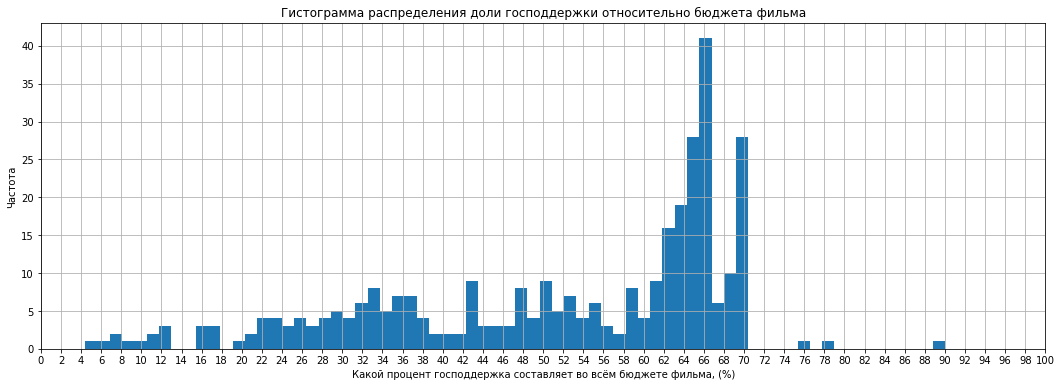

In [33]:
fig, ax = plt.subplots(figsize=(18, 6))
mkrf['support_ratio'].plot(kind='hist', bins=70, grid=True, ax=ax)
ax.set_title('Гистограмма распределения доли господдержки относительно бюджета фильма')
ax.set_xlabel('Какой процент господдержка составляет во всём бюджете фильма, (%)')
ax.set_ylabel('Частота')
_ = ax.xaxis.set_ticks(np.arange(0, 102, 2))

mkrf['support_ratio'].to_frame().describe()

Можно сделать вывод, что в среднем `52%` бюджета приходится на оказанную государством господдержку, медианное значение составляет около `60%`.

### Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

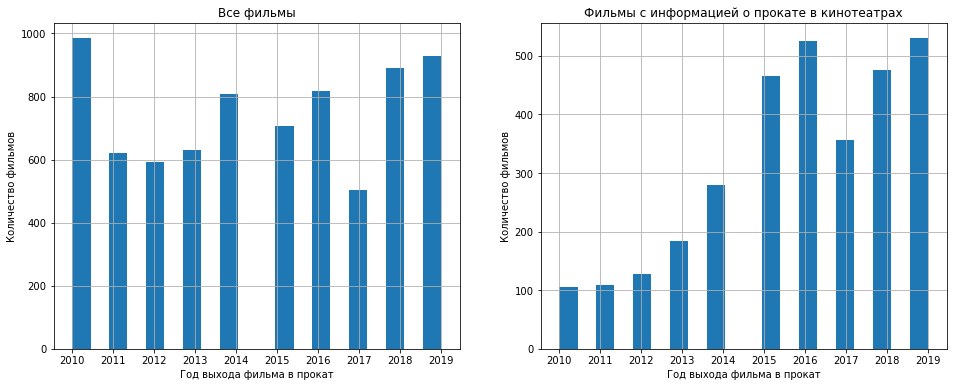

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
bins = 20
range_years = (2010, 2019)

mkrf['year'].plot(kind='hist', grid=True, bins=bins, range=range_years,
                  title='Все фильмы', ax=axes[0])

mkrf[mkrf['box_office'].notna()]['year'].plot(kind='hist', grid=True, bins=bins, range=range_years,
                  title='Фильмы с информацией о прокате в кинотеатрах', ax=axes[1])

for i in range(2):
    _ = axes[i].set_xlabel('Год выхода фильма в прокат')
    _ = axes[i].set_ylabel('Количество фильмов')
    _ = axes[i].set_xticks(range(2010, 2020))

In [35]:
all_movies_count = mkrf['title'].count()
movies_in_cinema_count = mkrf[mkrf['box_office'].notna()]['title'].count()
movies_in_cinema_ratio = movies_in_cinema_count / all_movies_count

print(f"Всего фильмов: {all_movies_count}")
print(f"Фильмов с информацией о прокате в кинотеатрах: {movies_in_cinema_count}")
print(f"Доля фильмов с информацией о прокате в кинотеатрах относительно всех фильмов составляет: {movies_in_cinema_ratio:.3%}")

Всего фильмов: 7486
Фильмов с информацией о прокате в кинотеатрах: 3158
Доля фильмов с информацией о прокате в кинотеатрах относительно всех фильмов составляет: 42.185%


**Вывод**

Информация о прокате известна для чуть менее чем половины всех фильмов набора данных - примерно `42%`.

Очень любопытны гистограммы с распределением выхода фильмов в прокат по годам:

- для всех фильмов наиболее часто встречается `2010` год, затем после 3 лет пребывания на одном уровне количество фильмов растёт в `2014` и `2016` годах, также явно заметен спад до минимального значения в `2017` году, после чего наблюдается заметный рост в `2018` и `2019` годах;


- для фильмов с данными о прокате в кинотеатрах видна яркая тенденция на увеличения количества вышедших фильмов с каждым годом, данная тенденция продолжается с `2010` до `2016` год включительно, после чего, как и в случае с первой гистограммой, идёт заметный спад в `2017` году с последующим ростом в `2018` и `2019` годах.

-----------------------------------

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

Оценим динамику с помощью группировки и столбчатых диаграмм для среднего и суммы сборов по годам. В силу того, что значения оказались очень различными до `2014` года и после него, используем отдельные столбчатые диаграммы для двух этих периодов:

,year,box_office_mean,box_office_median,box_office_sum,box_office_count
0,2010,23130.038,1700.000,2428654.000,105
1,2011,129383.165,3000.000,14102765.000,109
2,2012,54339.242,5660.000,6955423.000,128
3,2013,161954.925,3522.500,29799706.200,184
4,2014,26684415.266,18160.000,7444951859.200,279
5,2015,84940570.315,4920933.000,39497365196.400,465
6,2016,91000569.852,3846679.410,47866299741.910,526
7,2017,136032793.326,9968340.000,48563707217.510,357
8,2018,104565059.230,8891102.210,49668403134.320,475
9,2019,91369261.848,4627798.345,48425708779.590,530


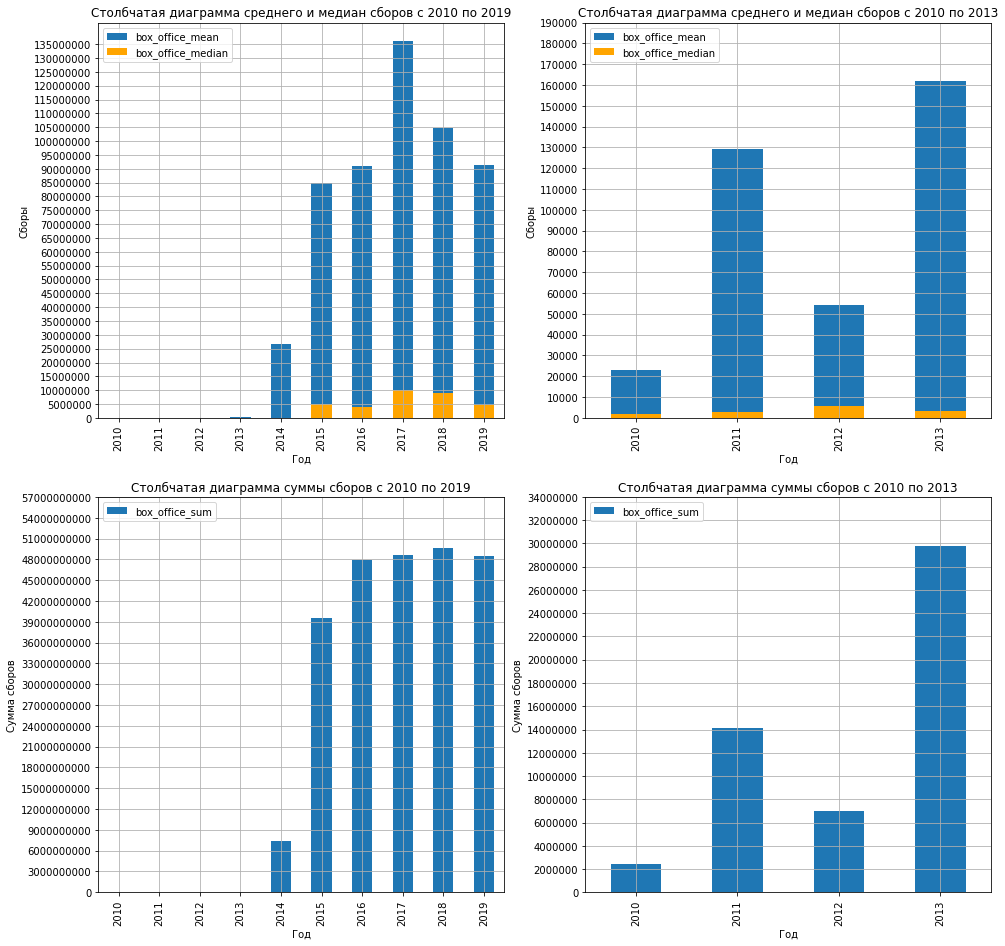

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

def set_plot_params(ax, ylabel, title):
    '''Вспомогательная функция для установки дополнительных параметров оси и графика
    '''
    ax.set_xlabel('Год')
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_title(title)

gb_2010_2019 =  mkrf.groupby('year')\
    .agg(box_office_mean=('box_office', 'mean'),
         box_office_median=('box_office', 'median'),
         box_office_sum=('box_office', 'sum'),
         box_office_count=('box_office', 'count'))\
    .reset_index()

gb_2010_2013 = mkrf[mkrf['year'] < 2014].groupby('year')\
    .agg(box_office_mean=('box_office', 'mean'),
         box_office_median=('box_office', 'median'),
         box_office_sum=('box_office', 'sum'))\
    .reset_index()

display(gb_2010_2019)

################################################
# Средние значения и медианы сборов по годам
################################################
_ = gb_2010_2019.plot(kind='bar', x='year', y='box_office_mean',
                            yticks=range(0, 140_000_000, 5_000_000), grid=True, ax=axs[0][0])
_ = gb_2010_2019.plot(kind='bar', x='year', y='box_office_median',
                            yticks=range(0, 140_000_000, 5_000_000), grid=True, color="orange", ax=axs[0][0])
set_plot_params(axs[0][0], 'Сборы', 'Столбчатая диаграмма среднего и медиан сборов с 2010 по 2019')

_ = gb_2010_2013.plot(kind='bar', x='year', y='box_office_mean',
                            yticks=range(0, 200_000, 10_000), grid=True, ax=axs[0][1])
_ = gb_2010_2013.plot(kind='bar', x='year', y='box_office_median',
                            yticks=range(0, 200_000, 10_000), grid=True, color="orange", ax=axs[0][1])
set_plot_params(axs[0][1], 'Сборы', 'Столбчатая диаграмма среднего и медиан сборов с 2010 по 2013')

################################################
# Сумма сборов по годам
################################################
_ = gb_2010_2019.plot(kind='bar', x='year', y='box_office_sum',
                           yticks=range(0, 60_000_000_000, 3_000_000_000), grid=True, ax=axs[1][0])
set_plot_params(axs[1][0], 'Сумма сборов', 'Столбчатая диаграмма суммы сборов с 2010 по 2019')

_ = gb_2010_2013.plot(kind='bar', x='year', y='box_office_sum',
                           yticks=range(0, 35_000_000, 2_000_000), grid=True, ax=axs[1][1])
set_plot_params(axs[1][1], 'Сумма сборов', 'Столбчатая диаграмма суммы сборов с 2010 по 2013')

**Вывод**

1. Сразу бросаются в глаза очень низкие показатели сборов в период с `2010` по `2013` года. В выведенной группировке видно, что в эти года представлено не так много фильмов (столбец `box_office_count`) чтобы получить значительные суммарные сборы, но и меры центральной тенденции - среднее и особенно медиана - также крайне малы по сравнению с периодом после `2014` года;


2. На первых двух диаграммах, отображающих средние и медианы, видно, насколько медианные значения меньше средних значений, которые подвержены влиянию выбросов. Это касается и периода до `2014`, и периода после `2014` года;


3. Оценивая медианные показатели сборов, можно сделать вывод, что они росли с `2010` по `2012` года, затем незначительно снизились в `2013` году, после чего произошёл резкий скачок вверх в `2015` году, некоторое снижение в `2016` году сменилось высокими значениями в `2017` (это максимальная медиана по годам) и в `2018` году, и в `2019` году показатель вышел примерно на уровень `2015` года;


4. Сумма сборов была **минимальной** в `2010` году - `2 428 654 ₽`. Но тут необохдимо заметить, что по этому же году представлено и меньше всего фильмов - `105`, и это безусловно влияет на полученное суммарное значение.


5. Сумма сборов была **максимальной** в `2018` году - `49 668 403 134 ₽`, это значение получено по `475` фильмам (в `4.75` раза больше фильмов, чем в `2010` году, а сборов больше аж в `20451` раз (`49 668 403 134 / 2 428 654`). В целом же суммарные сборы с `2016` по `2019` год находятся примерно на одном уровне.

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

Строим сводную таблицу и график по ней:

,year,mean,median
,,box_office,box_office
0,2010,23130.038,1700.000
1,2011,129383.165,3000.000
2,2012,54339.242,5660.000
3,2013,161954.925,3522.500
4,2014,26684415.266,18160.000
5,2015,84940570.315,4920933.000
6,2016,91000569.852,3846679.410
7,2017,136032793.326,9968340.000
8,2018,104565059.230,8891102.210


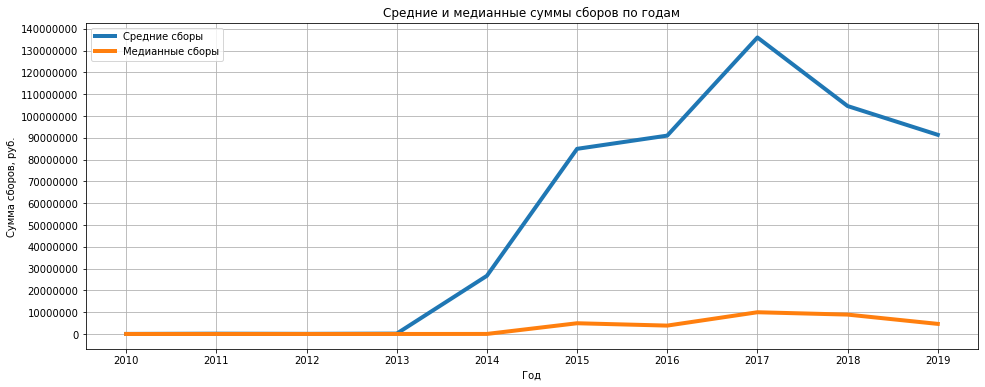

In [37]:
pivot_table = pd.pivot_table(mkrf, index='year', values='box_office', aggfunc=['mean', 'median']).reset_index()
pivot_table.reset_index(drop=True)
display(pivot_table)

fig, ax = plt.subplots(figsize=(16, 6))
_ = sns.lineplot(x=pivot_table['year'], y=pivot_table['mean']['box_office'],
                 label='Средние сборы', linewidth=4, ax=ax)
_ = sns.lineplot(x=pivot_table['year'], y=pivot_table['median']['box_office'],
                 label='Медианные сборы', linewidth=4, ax=ax)
_ = ax.ticklabel_format(axis='y', style='plain')
_ = ax.set_xticks(range(2010, 2020))
_ = ax.set_yticks(range(0, 150_000_000, 10_000_000))
_ = ax.set_title('Средние и медианные суммы сборов по годам')
_ = ax.set_xlabel('Год')
_ = ax.set_ylabel('Сумма сборов, руб.')
_ = ax.legend(loc='upper left')
_ = ax.grid()

Теперь убедимся, что значения в сводной таблице совпадают со значениями, полученными с помощью группировки `gb_2010_2019`, построенной выше:

In [38]:
pd.concat([pivot_table.loc[:, 'mean'], gb_2010_2019.loc[:, 'box_office_mean']], axis=1)

,box_office,box_office_mean
0,23130.038,23130.038
1,129383.165,129383.165
2,54339.242,54339.242
3,161954.925,161954.925
4,26684415.266,26684415.266
5,84940570.315,84940570.315
6,91000569.852,91000569.852
7,136032793.326,136032793.326
8,104565059.230,104565059.230
9,91369261.848,91369261.848


- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

Начнём с того, что построим столбчатые диаграммы по показателям сборов (средние, медианы, суммы) в зависимости от возрастного ограничения:

,age_restriction,box_office_mean,box_office_median,box_office_sum,box_office_count
0,«0+» - для любой зрительской аудитории,8890960.725,2943318.700,809077425.970,91
1,«12+» - для детей старше 12 лет,174193812.150,5065044.250,60619446628.330,348
2,«16+» - для детей старше 16 лет,94453085.272,5600007.000,76034733643.630,805
3,«18+» - запрещено для детей,51464161.076,6154439.170,40759615572.120,792
4,«6+» - для детей старше 6 лет,176020854.258,13736207.980,55798610799.680,317


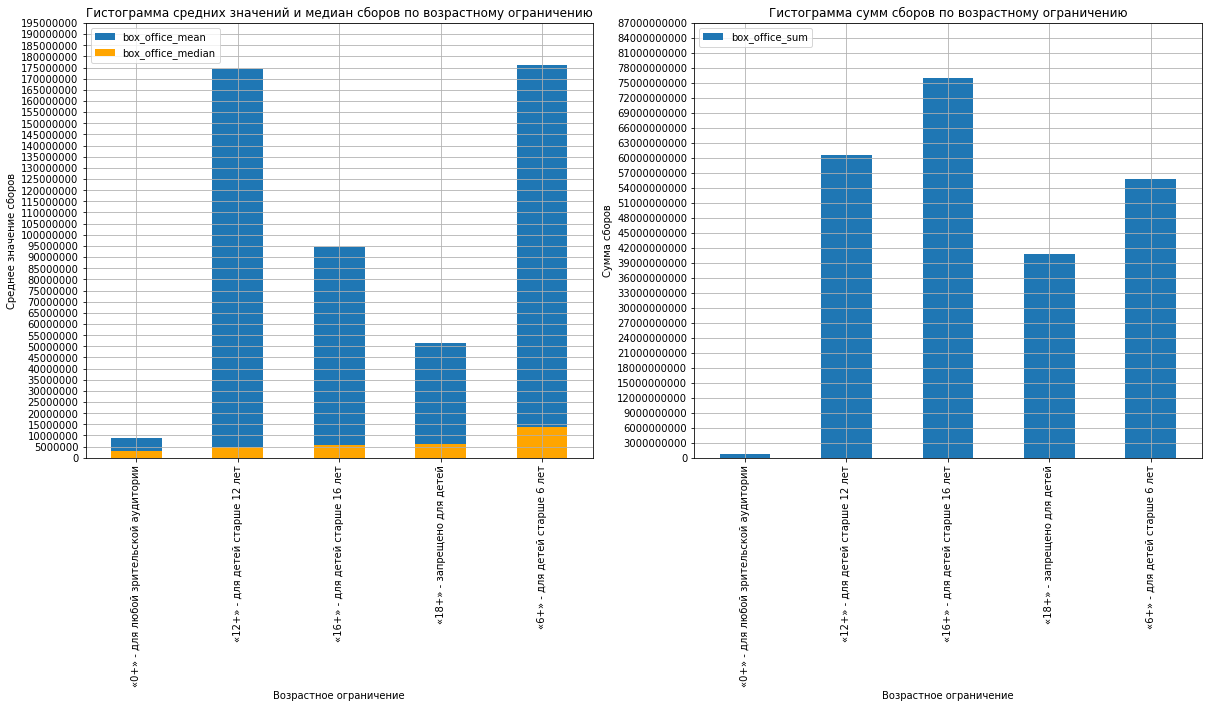

In [39]:
# Рассматриваем фильмы с 2015 года
mkrf_2015_2019 = mkrf[mkrf['year'] >= 2015]

gb_age_restriction = mkrf_2015_2019.groupby('age_restriction').agg(
    box_office_mean=('box_office', 'mean'),
    box_office_median=('box_office', 'median'),
    box_office_sum=('box_office', 'sum'),
    box_office_count=('box_office', 'count')).reset_index()

display(gb_age_restriction)

def set_plot_params(ax, ylabel, title):
    '''Вспомогательная функция для установки дополнительных параметров оси и графика
    '''
    ax.set_xlabel('Возрастное ограничение')
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_title(title)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

###########################################################
# Средние и медианы сборов по возрастному ограничению
###########################################################
_ = gb_age_restriction.plot(kind='bar', x='age_restriction', y='box_office_mean',
                            yticks=range(0, 200_000_000, 5_000_000), grid=True, ax=axs[0])
_ = gb_age_restriction.plot(kind='bar', x='age_restriction', y='box_office_median', color='orange',
                            yticks=range(0, 200_000_000, 5_000_000), grid=True, ax=axs[0])
set_plot_params(axs[0], 'Среднее значение сборов',
                'Гистограмма средних значений и медиан сборов по возрастному ограничению')

###########################################################
# Суммы сборов по возрастному ограничению
###########################################################
_ = gb_age_restriction.plot(kind='bar', x='age_restriction', y='box_office_sum',
                            yticks=range(0, 90_000_000_000, 3_000_000_000), grid=True, ax=axs[1])
set_plot_params(axs[1], 'Сумма сборов', 'Гистограмма сумм сборов по возрастному ограничению')

Судя по всему, возрастная категория действительно влияет на сборы - минимальное значение по всем представленным показателем - среднему, медиане и сумме сборов наблюдается в категории _«0+» - для любой зрительской аудитории_, но нужно отметить, что таких фильмов меньше всего, только `91`, что, впрочем, затрагивает только сумму сборов, но не показатели центральной тенденции.

Максимальное значение по среднему и медиане наблюдается в возрастной категории _«6+» - для детей старше 6 лет_ (`317` фильмов), с небольшим отставанием по среднему идёт категория _«12+» - для детей старше 12 лет_ (`348` фильмов).

Если говорить о максимальной сумме сборов, то описанные выше две категории _«6+»_ и _«12+»_ заметно ниже категории, на которой достигается максимум - _«16+» - для детей старше 16 лет_. Объяснение этому видится (но лишь отчасти) в значительном количестве фильмов, вышедших в данной возрастной категории - `805` фильмов.

В то же время одно лишь количество фильмов никак не гарантирует максимальных сборов, в чём можно убедиться глядя на весьма скромные (лишь 4 место) показатели суммарных сборов по возрастной категории _«18+» - запрещено для детей_, в то время как число фильмов в ней весьма велико - `792` - и сравнимо с количеством фильмов в категории с максимальными суммарными сборами.

Исследование зависимости максимальных суммарных сборов от года выхода фильма в прокат начнём с построения группировки по двум категориям - возрастному ограничению (`age_restriction`) и году (`year`). Результаты группировки выведем с сортировкой по убыванию суммарных сборов:

In [40]:
gb_age_restriction_year = (
    mkrf_2015_2019.groupby(['age_restriction', 'year'])
        .agg(box_office_sum=('box_office', 'sum'),
             box_office_count=('box_office', 'count'))
        .reset_index()
        .sort_values(by='box_office_sum', ascending=False)
)

display(gb_age_restriction_year)

,age_restriction,year,box_office_sum,box_office_count
12,«16+» - для детей старше 16 лет,2017,18745042900.060,121
11,«16+» - для детей старше 16 лет,2016,16664548541.740,182
13,«16+» - для детей старше 16 лет,2018,16503602346.960,156
8,«12+» - для детей старше 12 лет,2018,14267291660.690,67
5,«12+» - для детей старше 12 лет,2015,13616082008.910,73
24,«6+» - для детей старше 6 лет,2019,12852548650.860,81
14,«16+» - для детей старше 16 лет,2019,12753418984.600,178
9,«12+» - для детей старше 12 лет,2019,12680198773.670,85
6,«12+» - для детей старше 12 лет,2016,12204446524.390,82
22,«6+» - для детей старше 6 лет,2017,12086142145.760,45


Результаты подтверждают наблюдения построенных выше диаграмм, но лишь частично: категория _«16+» - для детей старше 16 лет_ демонстрирует максимальные (в целом) значения сумм сборов по `2016`, `2017` и `2018` годам.

По `2019` году категория _«16+»_ уступила первое место (правда, лишь с небольшим отставанием) категории _«6+» - для детей старше 6 лет_.

По `2015` году категория _«16+»_ вновь вторая, наибольшие сборы здесь с довольно заметным отрывом занимает категория _«12+» - для детей старше 12 лет_.

Делать подобные выводы по табличным данным не очень удобно, поэтому дополним исследование графическим представлением, где по оси `x` будут располагаться значения суммарных сборов, по оси `y` - возрастные ограничения, а каждый год будет визуализирован на своём графике. Такие графики не дают возможности оценить точные значения показателей, но кажутся весьма удобными для сравнения значений между собой по принципу "больше-меньше":

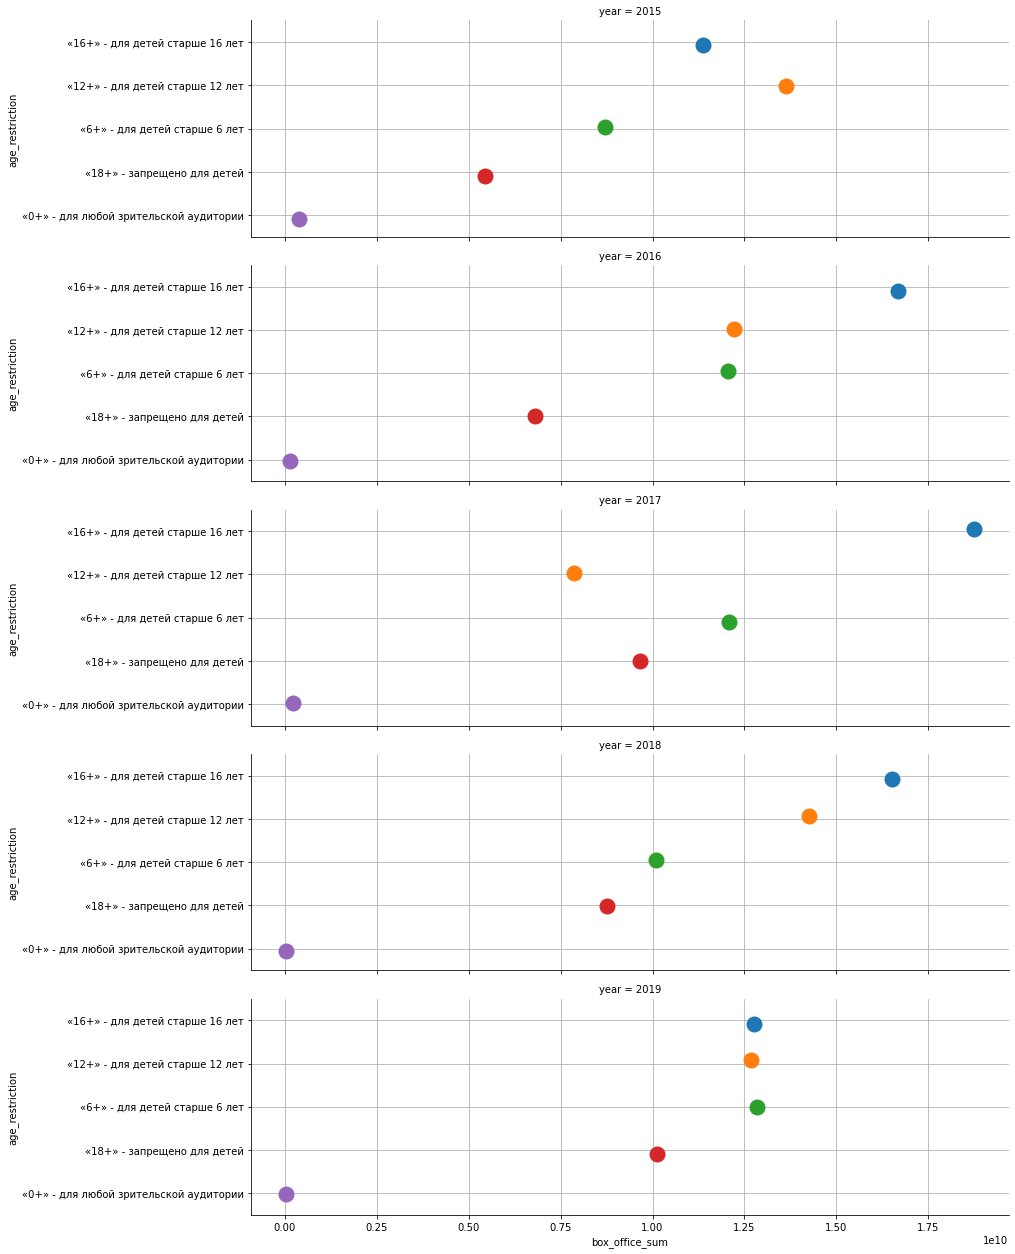

In [41]:
catplot = sns.catplot(x="box_office_sum", y="age_restriction", row="year",
                      height=3.5, aspect=4, s=16, data=gb_age_restriction_year)
for ax in catplot.axes.flat:
    ax.grid(True, axis='both')

Таким образом, на вопрос "_Меняется ли картина по максимальным суммарным сборам в рамках возрастным категорий в зависимости от года?_" можно ответить утвердительно - да, меняется, так произошло в `2015` и `2019` годах, когда категория _«16+»_ уступила своё первенство категории _«12+»_ в `2015` году и категории `«6+»` в `2019` году.

Чтобы сделать некоторые предположения о причинах данного наблюдения, попробуем проанализировать наиболее кассовые (топ-10) фильмы в `2015` и `2019` годах в рамках описанных категорий _«12+»_ (для `2015` года), _«6+»_ (для `2019` года) и _«16+»_ (и для `2015`, и для `2019` года):

In [42]:
display(
    mkrf_2015_2019[(mkrf_2015_2019['year'] == 2015) & 
                   (mkrf_2015_2019['age_restriction'] == '«12+» - для детей старше 12 лет') &
                   (mkrf_2015_2019['box_office'].notna())][['title', 'box_office']]
    .sort_values(by='box_office', ascending=False)
    .iloc[:10]
)

display(
    mkrf_2015_2019[(mkrf_2015_2019['year'] == 2015) & 
                   (mkrf_2015_2019['age_restriction'] == '«16+» - для детей старше 16 лет') &
                   (mkrf_2015_2019['box_office'].notna())][['title', 'box_office']]
    .sort_values(by='box_office', ascending=False)
    .iloc[:10]
)

,title,box_office
3117,Звёздные войны: Пробуждение силы,1658861425.500
2159,Мстители: Эра Альтрона,1500989281.900
2579,Мир Юрского периода,1211158990.000
2509,Терминатор: Генезис,1060054283.000
2599,Эверест (2015),630550647.800
2623,Человек-муравей,587487039.900
2401,Восхождение Юпитер,581522463.100
2616,Агенты А.Н.К.Л,573332918.400
2721,Разлом Сан-Андреас,535810483.900
1915,"Дивергент, глава 2: Инсургент",490175572.400


,title,box_office
2105,Форсаж 7,1486131019.000
2559,007: Спектр,767274597.900
2701,Самый Лучший День,683029061.400
2824,Голодные игры: Сойка-пересмешница. Часть 2,666653511.400
2561,Безумный Макс: Дорога ярости,650165993.510
2766,Последний охотник на ведьм,571224107.200
2645,Миссия невыполнима: Племя изгоев,569488830.300
2633,Бегущий в лабиринте: Испытание огнем /По произ...,484055452.700
2058,Дуxless 2,446163511.000
1898,Робот по имени Чаппи,398883270.600


В таблицах выше сразу же бросается в глаза тот факт, что в `2015` году в категории _«12+»_ вышло аж 4 фильма со значением сборов более 1 млрд. ₽ ("_Звёздные войны: Пробуждение силы_", "_Мстители: Эра Альтрона_", "_Мир Юрского периода_" и "_Терминатор: Генезис_").

В то же время в категории _«16+»_ фильм с такими сборами был только один ("_Форсаж 7_").

Такая разница в сборах, возможно, могла бы быть нивелирована, если бы фильмов в категории _«16+»_ было значительно больше, чем фильмов в категории _«12+»_, но, судя по всему, здесь разница в количестве вышедших фильмов не оказалась настолько значительной, чтобы это произошло:

- _«16+»_ - `168` фильмов;

- _«12+»_ - `73` фильма

Теперь попробуем посмотреть на данные по `2019` году в контексте категорий _«16+»_ и _«6+»_:

In [43]:
display(
    mkrf_2015_2019[(mkrf_2015_2019['year'] == 2019) & 
                   (mkrf_2015_2019['age_restriction'] == '«6+» - для детей старше 6 лет') &
                   (mkrf_2015_2019['box_office'].notna())][['title', 'box_office']]
    .sort_values(by='box_office', ascending=False)
    .iloc[:10]
)

display(
    mkrf_2015_2019[(mkrf_2015_2019['year'] == 2019) & 
                   (mkrf_2015_2019['age_restriction'] == '«16+» - для детей старше 16 лет') &
                   (mkrf_2015_2019['box_office'].notna())][['title', 'box_office']]
    .sort_values(by='box_office', ascending=False)
    .iloc[:10]
)

,title,box_office
7216,Малефисента: Владычица тьмы,1911944865.950
7383,Холодное сердце II,1827244672.810
6715,Как приручить дракона 3,1689540830.240
6957,Тайная жизнь домашних животных 2,1478921168.460
7273,Эверест,689483900.110
7118,Angry Birds 2 в кино,517116584.520
7466,Иван Царевич и Серый Волк 4,501069235.000
7017,История игрушек 4,487397070.110
6819,Дамбо,472692133.490
7453,Фиксики против кработов,387590521.720


,title,box_office
6820,Мстители: Финал,2576613776.830
6728,Капитан Марвел,1144426298.040
6684,Алита: Боевой ангел,757864674.990
6583,Стекло,643121241.370
6545,Зеленая книга,573225709.240
6663,Громкая связь,524897298.170
7332,Терминатор: Темные судьбы,490745769.350
6632,Бабушка лёгкого поведения 2,439776371.250
6965,Люди Икс: Темный феникс,418607611.600
7319,Достать ножи,371749522.960


Есть ощущения, что и здесь наблюдается схожая картина - в `2019` году в детской категории _«6+»_ в прокат вышла кассовая "_Малефисента: Владычица тьмы_" и сразу несколько успешных мультфильмов ("_Холодное сердце II_", "_Как приручить дракона 3_" и "_Тайная жизнь домашних животных 2_") - сборы по каждому из них преодолели отметку в 1 млрд. ₽.

В категории _«16+»_ подобных фильмов вышло только 2: "_Мстители: Финал_" и "_Капитан Марвел_".

Здесь нужно отметить, что суммарные сборы по `2019` году по этим двум категориям очень близки между собой (категория _«16+»_ "почти догнала" категорию _«6+»_). Вероятно, этому поспособствовали очень высокие сборы по фильму "_Мстители: Финал_" - около 2.5 млрд. ₽, а также разница между количеством фильмов в категории _«6+»_ (`81` фильм) и категории _«16+»_ (`178` фильмов).

### Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

----------------------------

Тот факт, что каждый фильм получил ту или иную господдержку, либо возвратную, либо невозвратную, был установлен ранее.

Начнём с того, что оценим, сколько фильмов получили некоторую поддержку, сколько получили только возвратную поддержку, сколько получили только невозвратную поддержку:

In [44]:
films_with_support =\
    mkrf[(mkrf['refundable_support'] > 0) | (mkrf['nonrefundable_support'] > 0)]['title'].count()
films_with_only_ref_support =\
    mkrf[(mkrf['refundable_support'] > 0) & (mkrf['nonrefundable_support'] == 0)]['title'].count()
films_with_only_nonref_support =\
    mkrf[(mkrf['refundable_support'] == 0) & (mkrf['nonrefundable_support'] > 0)]['title'].count()
films_with_both_support =\
    mkrf[(mkrf['refundable_support'] > 0) & (mkrf['nonrefundable_support'] > 0)]['title'].count()

print(f"Фильмов с государственной поддержкой: {films_with_support} штук(а/и)")
print(f"Фильмов только с возвратной поддержкой: {films_with_only_ref_support} штук(а/и)")
print(f"Фильмов только с невозвратной поддержкой: {films_with_only_nonref_support} штук(а/и)")
print(f"Фильмов и с возвратной, и с невозвратной поддержкой: {films_with_both_support} штук(а/и)")

Фильмов с государственной поддержкой: 332 штук(а/и)
Фильмов только с возвратной поддержкой: 9 штук(а/и)
Фильмов только с невозвратной поддержкой: 221 штук(а/и)
Фильмов и с возвратной, и с невозвратной поддержкой: 102 штук(а/и)


Выясним теперь как менялись объёмы государственной поддержки кино по годам, для чего создадим группировку по полю `year`, выведем её ...

In [45]:
support_by_year = (
    mkrf.groupby('year')
        .agg(
            nref_mean=('nonrefundable_support', 'mean'),
            ref_mean=('refundable_support', 'mean'),
        
            nref_median=('nonrefundable_support', 'median'),
            ref_median=('refundable_support', 'median'),
        
            nref_sum=('nonrefundable_support', 'sum'),
            ref_sum=('refundable_support', 'sum'),
        
            nref_count=('nonrefundable_support', 'count'),
            ref_count=('refundable_support', 'count'))
        .reset_index()
)

display(support_by_year)

,year,nref_mean,ref_mean,nref_median,ref_median,nref_sum,ref_sum,nref_count,ref_count
0,2010,NaN,NaN,NaN,NaN,0.000,0.000,0,0
1,2011,NaN,NaN,NaN,NaN,0.000,0.000,0,0
2,2012,NaN,NaN,NaN,NaN,0.000,0.000,0,0
3,2013,67173972.500,0.000,67173972.500,0.000,134347945.000,0.000,2,2
4,2014,31312643.688,4437500.000,27500000.000,0.000,501002299.000,71000000.000,16,16
5,2015,35105678.372,7408757.198,27755000.000,0.000,3019088340.000,637153119.000,86,86
6,2016,55436975.115,15106557.377,30000000.000,0.000,3381655482.000,921500000.000,61,61
7,2017,60112799.537,17545045.878,30000000.000,5000000.000,2464624781.000,719346881.000,41,41
8,2018,49731597.589,11821428.571,30500000.000,0.000,2784969465.000,662000000.000,56,56
9,2019,56800000.000,13257142.857,35000000.000,0.000,3976000000.000,928000000.000,70,70


... а также построим графики для сумм возвратной и невозвратной поддержки по годам:

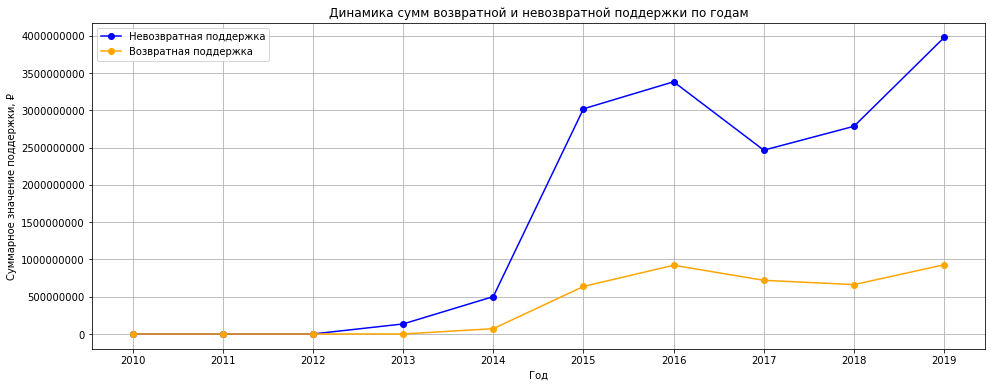

In [46]:
fig, ax = plt.subplots(figsize=(16, 6))

support_by_year.plot(kind='line', x='year', y='nref_sum',
                     grid=True, style='-o', color='blue', label='Невозвратная поддержка', ax=ax)
support_by_year.plot(kind='line', x='year', y='ref_sum',
                     grid=True, style='-o', color='orange', label='Возвратная поддержка', ax=ax)
_ = ax.set_xticks(range(2010, 2020))
_ = ax.ticklabel_format(axis='y', style='plain')
_ = ax.set_title('Динамика сумм возвратной и невозвратной поддержки по годам')
_ = ax.set_xlabel('Год')
_ = ax.set_ylabel('Суммарное значение поддержки, ₽')

Глядя на график и на вывод группировки, можно сделать такие выводы:


- государство тратит больше на невозвратную поддержку, возможные причины этого, связанные с поручительством, уже были описаны ранее;


- с `2010` по `2012` года включительно государство не предоставляло ни возвратную, ни невозвратную поддержку кино;


- начиная с `2013` года видна явная тенденция на увеличение объёмов финансирования, причём это касается как возвратной, так и невозвратной поддержки, тенденция сохранялась вплоть до `2016` года включительно;


- в `2017` году по каким-то причинам было снижено финансирование кино, это коснулось обеих видов поддержки, но в большей степени невозвратной;


- в `2018` году произошло увеличение невозвратной поддержки, возвратная при этом оставалась примерно на том же уровне;


- в `2019` году вновь наблюдается рост обеих видов поддержки, причём довольно резкий, особенно это касается невозвратной поддержки;


- в `2019` году зарегистрировано максимальное значение как невозвратной, так и возвратной поддержки по всем годам.

Теперь попробуем проанализировать зависимость государственной поддержки от возрастного ограничения фильма - возможно, фильмы с какими-то определёнными ограничениями финансируются более охотно, чем другие:

In [47]:
support_by_age_restriction = (
    mkrf.groupby('age_restriction')
        .agg(
            nref_mean=('nonrefundable_support', 'mean'),
            ref_mean=('refundable_support', 'mean'),
        
            nref_median=('nonrefundable_support', 'median'),
            ref_median=('refundable_support', 'median'),
        
            nref_sum=('nonrefundable_support', 'sum'),
            ref_sum=('refundable_support', 'sum'),
        
            nref_count=('nonrefundable_support', 'count'),
            ref_count=('refundable_support', 'count'))
        .reset_index()
)

display(support_by_age_restriction)

,age_restriction,nref_mean,ref_mean,nref_median,ref_median,nref_sum,ref_sum,nref_count,ref_count
0,«0+» - для любой зрительской аудитории,28565000.000,5625000.000,29500000.000,0.000,228520000.000,45000000.000,8,8
1,«12+» - для детей старше 12 лет,58791454.387,14787735.849,30000000.000,0.000,6231894165.000,1567500000.000,106,106
2,«16+» - для детей старше 16 лет,37871201.600,6681224.952,28000000.000,0.000,4733900200.000,835153119.000,125,125
3,«18+» - запрещено для детей,35000000.000,1155245.750,30000000.000,0.000,980000000.000,32346881.000,28,28
4,«6+» - для детей старше 6 лет,62882676.108,22446153.846,40000000.000,0.000,4087373947.000,1459000000.000,65,65


Получив таблицу для нашей группировки, строим столбчатую диаграмму:

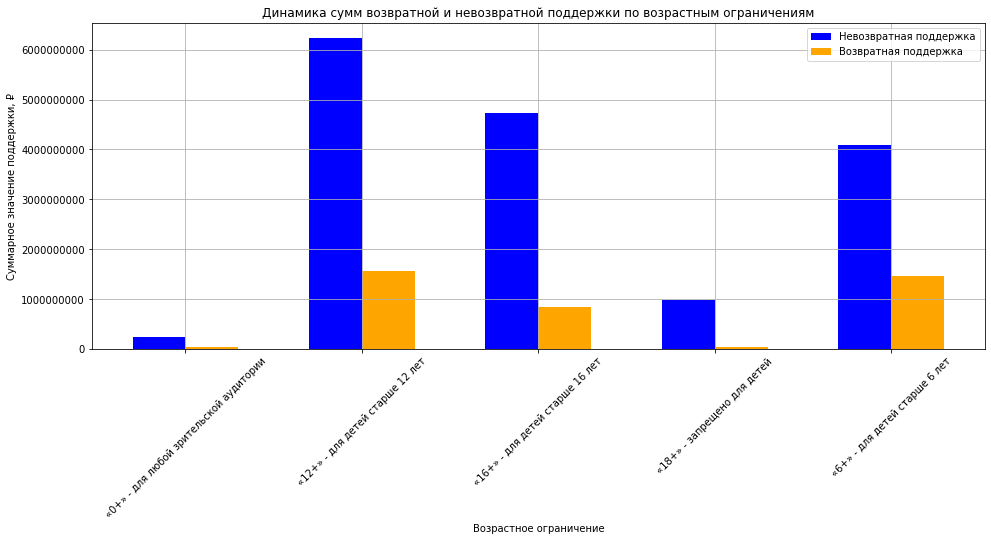

In [48]:
fig, ax = plt.subplots(figsize=(16, 6))

age_restrictions = [
    '«0+» - для любой зрительской аудитории',
    '«12+» - для детей старше 12 лет',
    '«16+» - для детей старше 16 лет',
    '«18+» - запрещено для детей',
    '«6+» - для детей старше 6 лет'
]

ind = np.arange(len(age_restrictions))
width = 0.3
ax.bar(ind, support_by_age_restriction['nref_sum'], width,
                                color='blue', label='Невозвратная поддержка')
ax.bar(ind + width, support_by_age_restriction['ref_sum'], width,
                                color='orange', label='Возвратная поддержка')
_ = plt.xticks(ind + width / 2, age_restrictions)
_ = ax.ticklabel_format(axis='y', style='plain')
_ = ax.tick_params(axis='x', rotation=45)
_ = ax.set_title('Динамика сумм возвратной и невозвратной поддержки по возрастным ограничениям')
_ = ax.set_xlabel('Возрастное ограничение')
_ = ax.set_ylabel('Суммарное значение поддержки, ₽')
_ = ax.grid()
_ = ax.legend()

Здесь можно сделать такие выводы:

- поскольку здесь мы исследуем суммарные объёмы поддержки, то скромные показатели в категориях _«0+»_ и _«18+»_ обусловлены по всей видимости малым количеством фильмов в данных возрастных ограничениях - `8` и `28` фильмов соответственно;


- для возрастных ограничений _«12+»_ и _«16+»_ примерно сохраняется пропорция между невозвратной и возвратной поддержкой;


- категория с ограничением _«6+»_ по количеству фильмов (`65`) отличается примерно в 2 раза от категории _«16+»_ (`125`), но столбчатая диаграмма показывает, что объём невозвратной поддержки для категории _«6+»_ лишь незначительно отстаёт от значения этого показателя для категории _«16+»_, а объём возвратной поддержки для фильмов в категории _«6+»_ (где фильмов меньше) и вовсе превосходит это значение для категории _«16+»_ (где фильмов больше). Причины этих высоких значений поддержки для категории _«6+»_ на мой взгляд могли бы быть связаны с тем, что фильмы в категории _«6+»_ (половина из которых мультфильмы - группировка ниже демонстрирует это) ориентированы в первую очередь на детей, и поэтому имеют некоторую сюжетную схожесть и определённую предсказуемость по сборам. И раз фильмы и мультфильмы для детей обладают такой предсказуемостью по будущим сборам, то создатели могут более уверенно запрашивать поддержку (в том числе возвратную!) у государства, раз они могут опираться на прогнозируемые показатели сборов. Но это моё предположение.

In [49]:
# Как распределяются фильмы по типам внутри возрастной категории '«6+» - для детей старше 6 лет'
(
    mkrf[mkrf['age_restriction'] == '«6+» - для детей старше 6 лет']
        .groupby('type')
        .agg(title_count=('title', 'count'))
        .reset_index()
)

,type,title_count
0,Анимационный,264
1,Документальный,43
2,Научно-популярный,10
3,Прочие,31
4,Художественный,278


Попробуем теперь оценить окупаемость фильмов, получивших государственную поддержку. Будем рассматривать те фильмы, для которых непустыми являются категории `budget` и `box_office`.

Оценим количество таких фильмов:

In [50]:
mkrf_notna_condition = (mkrf['budget'].notna()) & (mkrf['box_office'].notna())
mkrf_notna = mkrf[mkrf_notna_condition]
mkrf_notna['title'].count()

318

Добавим новый столбец в наш набор данных, `is_paybacked`, которые будет отвечать на вопрос, окупился ли данный фильм в прокате. Считаем фильм окупившимся, если его сборы не меньше, чем бюджет:

In [51]:
mkrf['is_paybacked'] = mkrf.apply(lambda row: row['box_office'] >= row['budget'], axis=1)
mkrf_notna = mkrf[mkrf_notna_condition]
mkrf_notna.groupby('is_paybacked').agg(sum=('support', 'count'))

,sum
is_paybacked,
False,246
True,72


Можно видеть, что результаты окупаемости фильмов с государственной поддержкой весьма скромны - **из `318` фильмов окупилось только `72`, что составляет только `22,6%`**.

Попробуем теперь исследовать окупаемость в контексте, а именно ответить на вопросы:

- Зависит ли как-то окупаемость от года выхода фильма? Может быть был год с очень удачным финансированием фильмов, а какой-то год оказался особенно неудачным?


- Зависит ли как-то окупаемость от рейтинга? Можно ли утверждать, что окупаются приемущественно фильмы с высоким рейтингом?


- Зависит ли как-то окупаемость от объёмов государственной поддержки? Можно ли говорить, что для фильмов с объёмом поддержки более половины бюджета окупаемость выше?

Попробуем ответить на первый вопрос - какова была окупаемость по годам выхода фильма:

In [52]:
def create_groupby_for_paybacked(df, condition, category):
    '''Вспомогательная функция для создания группировки по категории "category" с добавлением в неё столбцов с информацией
    об окупаемости и последующего подсчёта процента окупившихся фильмов
    '''
    df_notna = df[condition]
    gb_paybacked = df_notna.groupby(category).agg(
        is_paybacked_sum=('is_paybacked', 'sum'),
        is_paybacked_count=('is_paybacked', 'count'))

    gb_paybacked['is_paybacked_percentage'] =\
        round((gb_paybacked['is_paybacked_sum'] / gb_paybacked['is_paybacked_count']) * 100).astype(int)
    gb_paybacked['is_paybacked_percentage_str'] = gb_paybacked['is_paybacked_percentage'].apply(lambda x: str(x) + '%')
    return gb_paybacked.reset_index()

gb_paybacked_year = create_groupby_for_paybacked(mkrf, mkrf_notna_condition, 'year')
display(gb_paybacked_year)

,year,is_paybacked_sum,is_paybacked_count,is_paybacked_percentage,is_paybacked_percentage_str
0,2013,0,2,0,0%
1,2014,3,16,19,19%
2,2015,16,85,19,19%
3,2016,10,60,17,17%
4,2017,14,39,36,36%
5,2018,18,56,32,32%
6,2019,11,60,18,18%


Можно увидеть, что результаты окупаемости разнятся по годам:

- в `2013` году не окупился ни один из 2 фильмов, которые получили поддержку;

- с `2014` по `2016` год окупаемость держалась примерно на одном уровне - порядка `18%`;

- с `2017` и `2018` год окупаемость выросла и превысила `30%`;

- в `2019` году показатель окупаемости выглядит довольно низким - значение вновь опустилось до `18%`.

Вообще, учитывая максимальное значение окупаемости в `36%`, достигнутое в `2017` году, стратегия финансирования в том году и сделанный выбор фильмов для поддержки могли бы быть изучены отдельно как пример удачного распределения средств государственной поддержки кино.

Попробуем теперь выяснить, зависит ли как-то окупаемость от рейтинга, и узнаем, можно ли сказать, что лучше окупаются фильмы с высоким рейтингом.

,ratings_bin,is_paybacked_sum,is_paybacked_count,is_paybacked_percentage,is_paybacked_percentage_str
0,0-2,0,1,0,0%
1,2-3,1,5,20,20%
2,3-4,1,12,8,8%
3,4-5,12,36,33,33%
4,5-6,16,78,21,21%
5,6-7,29,125,23,23%
6,7-8,10,40,25,25%
7,8-10,2,4,50,50%


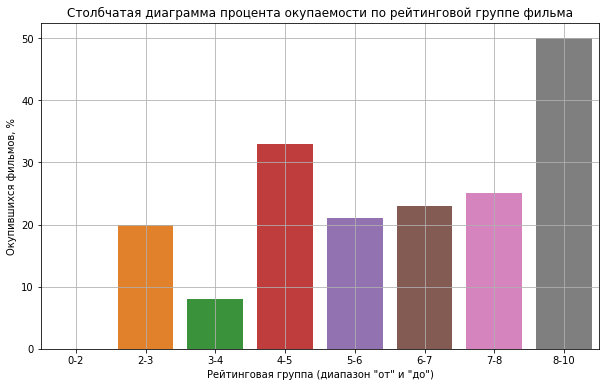

In [53]:
# Чтобы избежать деления на множество всевозможных рейтингов, создадим дополнительный столбец в таблице для
# хранения корзины (bin) рейтинга фильма, статистику по окупаемости будем рассматривать применительно к рейтинговым корзинам
ratings_cut_bins = [0, 2, 3, 4, 5, 6, 7, 8, 10]
ratings_cut_labels = ['0-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-10']
mkrf['ratings_bin'] = pd.cut(mkrf['ratings'], bins=ratings_cut_bins, labels=ratings_cut_labels)

gb_paybacked_ratings = create_groupby_for_paybacked(mkrf, mkrf_notna_condition, 'ratings_bin')
display(gb_paybacked_ratings)

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=gb_paybacked_ratings['ratings_bin'], y=gb_paybacked_ratings['is_paybacked_percentage'])
_ = ax.grid()
_ = ax.set_title('Столбчатая диаграмма процента окупаемости по рейтинговой группе фильма')
_ = ax.set_xlabel('Рейтинговая группа (диапазон "от" и "до")')
_ = ax.set_ylabel('Окупившихся фильмов, %')

Глядя на таблицу с группировкой и столбчатую диаграмму выше, можно сделать такие выводы:

- хуже всего окупаются фильмы в рейтинговой корзине `"3-4"` (процент окупаемости `8%`);


- фильмы с рейтингом от `2` до `3` (корзина `"2-3"`) окупаются на уровне `20%`, что в два раза выше, чем у фильмов с рейтингом `"3-4"`. Правда, таких фильмов всего `5`. Можно предположить, что здесь окупаемость достигается на низкосортных современных комедиях, которые киноманами оцениваются низко, но при этом могут окупиться просто в силу своей лёгкости восприятия/доступности и большого количества посмотревших их зрителей;


- окупаемость фильмов в рейтинговых корзинах `5-6`, `6-7` и `7-8` находится примерно на одном уровне, где-то между `20%` и `30%`;


- наибольшая окупаемость в виде `50%` достигается у фильмов в самой высокой рейтинговой корзине - `"8-10"`, что, конечно, не может не радовать, но число фильмов здесь крайне мало - всего `4`.

Наконец, выясним, зависит ли как-то окупаемость от объёмов государственной поддержки:

,support_ratio_bin,is_paybacked_sum,is_paybacked_count,is_paybacked_percentage,is_paybacked_percentage_str
0,"(0, 25]",6,29,21,21%
1,"(25, 50]",28,98,29,29%
2,"(50, 75]",37,188,20,20%
3,"(75, 100]",1,3,33,33%


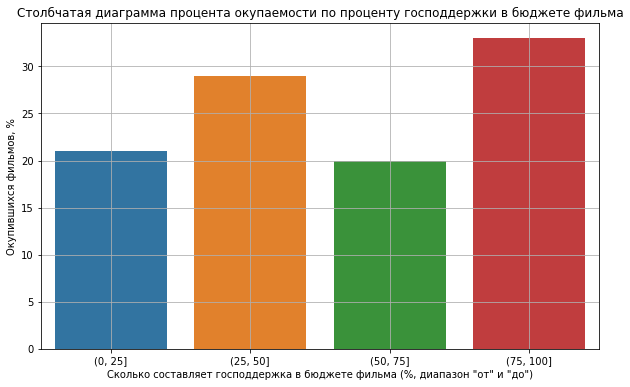

In [54]:
# Здесь вновь используем корзины для деления доли (процентов) господдержки в бюджете фильма
support_ratio_cut_bins = [0, 25, 50, 75, 100]
mkrf['support_ratio_bin'] = pd.cut(mkrf['support_ratio'], bins=support_ratio_cut_bins)

gb_paybacked_support = create_groupby_for_paybacked(mkrf, mkrf_notna_condition, 'support_ratio_bin')
display(gb_paybacked_support)

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=gb_paybacked_support['support_ratio_bin'], y=gb_paybacked_support['is_paybacked_percentage'])
_ = ax.grid()
_ = ax.set_title('Столбчатая диаграмма процента окупаемости по проценту господдержки в бюджете фильма')
_ = ax.set_xlabel('Сколько составляет господдержка в бюджете фильма (%, диапазон "от" и "до")')
_ = ax.set_ylabel('Окупившихся фильмов, %')

Вид диаграммы не позволяет сделать вывод о том, что чем больше государственная поддержка фильма, тем вероятнее он окупится в прокате. Значения колеблятся от `20%` до `30%`, после возрастания доли окупившихся фильмов для корзины `"25%-50%"` следует заметный спад почти на `10%` - среди фильмов, доля господдержки в которых составляла от `50%` до `75%` бюджета, окупилось только `20%`. Максимальное значение процента окупаемости в `33%` наблюдается для последней корзины, где доля государственной поддержки составляет более `75%`, но как видно в таблице, таких фильмов было всего `3`, поэтому делать однозначные выводы здесь, я думаю, всё же не стоит.

### Шаг 5. Напишите общий вывод

#### Вам нужно изучить рынок российского кинопроката и выявить текущие тренды

Заметен рост количества выходящих фильмов в последние 2 года исследования (в `2018` и `2019`), который начался после спада в `2017` году, количество вышедших в `2019` году фильмов приблизилось к рекордному `2010` году, когда вышло наибольшее число фильмов.

Средние и медианные сборы в `2019` году не так велики, но суммарные сборы по `2019` году были высокими и оставались примерно на уровне периода с `2016` по `2018` года.

Видно, что в 2019 году суммарные сборы примерно сравнялись по возрастным категориям  _«6+»_, _«12+»_ и _«16+»_, в то время как в предыдущие года была заметна одна конктерная категория, занимающая лидирующую позиция по суммарным сборам (_«12+»_ в `2015` году и _«16+»_ в остальные года).

#### Уделите внимание фильмам, которые получили государственную поддержку. Попробуйте ответить на вопрос, насколько такие фильмы интересны зрителю

Государство начало оказывать финансовую поддержку кинематографу в `2013` году. В среднем же `52%` всего бюджета фильма приходится на оказанную государством господдержку (медианное значение составляет около `60%`). Б_о_льшее значение приходится на невозвратную поддержку.

Окупаемость фильмов, получивших государственную поддержку, весьма низка и составляет только лишь `22,6%` (из `318` фильмов окупилось только `72`).

В `2019` году наблюдается максимальное значение государственной поддержки по всем годам в исследовании. Тревожным фактором является то, что в этом же `2019` году наблюдается падение процента окупившихся фильмов - их только `18%` (окупились `11` фильмов из `60`), в то время как в `2018` году этот процент составлял `32%`. Здесь можно рекомендовать Фонду Кино исследовать стратегию господдержки, которой они придерживались в `2017` году, когда процент окупившихся фильмов с поддержкой был максимальным - `36%` (окупились `14` фильмов из `39`).

Утверждать, что чем выше рейтинг фильма на "Кинопоиске", тем лучше его показатель окупаемости, нельзя: фильмы с рейтингом от `4` до `5` имеют окупаемость в `33%`, в то время как окупаемость фильмов с рейтингом от `5` до `8` меньше либо равна `25%`.

Кроме того, нельзя говорить о влиянии объёма государственной поддержки фильма на окупаемость в прокате, в частности о том, что чем больше государственная поддержка, тем вероятнее фильм окупится в прокате.